<h1><center><b><u>EDA Notebook</u></b></center></h1>
This notebook contains the EDA section of the data & Feature selection process.<br>
Steps performed: -
<ul>
    <li>Processing of Loans data from "data_loans_5k" file & creation of Target based on max_dpd.</li>
    <li>Feature Engineering on loans data (i.e creation of column that has it's past default counts).</li>
    <li>Processing assessments data.</li>
    <li>Perform Left Join in Loans data & assessments data based on master_user_id & disbursed_at of loans & created_at of assessments.</li>
    <li>Join with only those assesments that happened before the disbursement of loan & only consider the latest assessment for that loan approval decision.</li>
    <li><b>Feature Selection: -</b>
    <ul>
        <li>Primary Feature Selection based on particular threshold of missing values in the data.</li>
        <li>Secondary Selection Based on basic domain knowledge.</li>
        <li>Graphical visualization between features with their Default/ No Default explaination power.</li>
        <li>Statistical technique (Weight of evidence) to get the important features.</li>
        <li>Using Weight of evidence to find out the bins for continuos variables, to transform them into categorical variables, which can be used as a band for that category group.</li>
    </ul>
    </li>
</ul>

<h2><u>Import Libraries</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandasql as ps
import warnings

In [2]:
# set basic notebook properties
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",50)

<h2><u>Data Preprocessing</u>

<h3>Loans data

In [3]:
default_df = pd.read_csv("data_loans_5k.csv",parse_dates=["disbursed_at"])

In [4]:
default_df["target"] = np.where(default_df["max_dpd"] > 30, "Default", "No Default")

No Default    3547
Default       1452
Name: target, dtype: int64


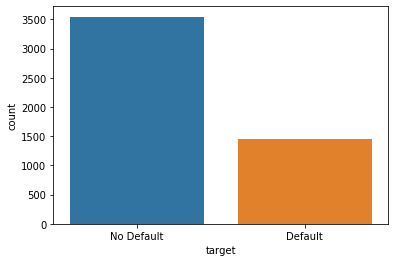

In [5]:
print(default_df["target"].value_counts())
sns.countplot(default_df["target"])
plt.show()

<h4>Below section will create two columns in loans dataframe</h4>
<ul>
    <li><b>past_default_count :- </b> This columns stores the information that how many time user has defaulted in past before applying for this loan.</li>
        <li><b>total_past_records :- </b> This columns stores the information about the user that for how many times he has applied for loans & get approved before this particular loan application disbursed.</li>
</ul>

In [6]:
sql_code = """
select A.*,
    CASE
        WHEN B.target = "Default" THEN 1
        ELSE 0
    END as past_default_count,
    CASE
        WHEN B.master_user_id is NOT NULL THEN 1
        ELSE 0
    END as total_past_records
from default_df as A
left join default_df as B
on A.master_user_id = B.master_user_id
and A.disbursed_at > B.disbursed_at
"""
intermediate_df = ps.sqldf(sql_code,locals())

def aggregator(df):
    """
    This Function accepts Loan dataframe grouped on user_id & disbursed_at
    Output:- return a Series object with two extra info :-
        1) past_default_count
        2) total_past_records
    """
    result = df.iloc[0]
    result["past_default_count"] = sum(df.past_default_count)
    result["total_past_records"] = sum(df.total_past_records) + 1
    return result

processed_loan_df = intermediate_df.groupby(["master_user_id",
                                             "disbursed_at"]).\
                                    apply(aggregator).\
                                    reset_index(drop=True)
del(intermediate_df)

In [7]:
processed_loan_df.head(2)

,boost_loan_id,max_dpd,current_dpd,no_of_paid_installments,no_of_missed_installments,is_non_starter,amount,disbursed_at,emi_amount,master_user_id,period,target,past_default_count,total_past_records
0,3,1.0,0.0,3,0,0,10000.0,2016-02-15 14:42:10.038000,3441.00,1,3,No Default,0,1
1,360,0.0,0.0,3,0,0,9000.0,2016-06-27 00:00:00.000000,3120.79,1,3,No Default,0,2


<h3>Assessments data</h3>

In [8]:
raw_assessments = pd.read_csv("data_assessments_5k.csv", parse_dates=["created_at"])

<h3>Join both Loan data & Assessments data</h3>
Join Condition: -
<ul>
    <li>master_user_id</li>
    <li>loans.disbursed_at > assessment.created_at</li>
    <li>Keep only the latest assessments which decided the loans approval decision</li>
</ul>
<b>Note: -</b> Reason behind removing all the assessments & keeping only the latest one is to get the assessment on which that loan is approved. as this is where we have to look what we can improve in our model to classify defaulters better

In [9]:
columns = [col for col in raw_assessments.columns if col !="master_user_id"]
column_string = "B." +", B.".join(columns)

In [10]:
sql_join = f"""
SELECT A.*,
    {column_string}
from processed_loan_df as A
left join raw_assessments as B
on A.master_user_id = B.master_user_id
    and A.disbursed_at > B.created_at
"""
joined_intermediate_df = ps.sqldf(sql_join, locals())

In [11]:
joined_intermediate_df = joined_intermediate_df.sort_values(by=["master_user_id", "created_at"])
joined_data = joined_intermediate_df.groupby(list(processed_loan_df.columns)).tail(1)
del(joined_intermediate_df)

In [12]:
# Final shape of joined dataframe
joined_data.shape

(4999, 463)

<h2><u>EDA  & Feature Selection</u></h2>

In [13]:
selected_features = []

<h3>Primary Selection</h3>
Discard those Feature which has more then 40% of values missing.<br>
Reason:- 
<ul>
    <li>When reduce that threshold to leeser percentage basically most of the Features are getting removed from assessments columns</li>
    <li>Increasing the threshold to more then that is not a good practice as in the end we have to impute them also which will create a lot of bias in the model.</li>
</ul>
<b>Note: -</b> Obtained that threshold after multiple runs

In [14]:
missing_threshold=40

def column_missing_counts_df(df, missing_threshold=20):
    total_records = len(df)
    result = pd.DataFrame()
    result["Columns"] = df.columns
    result["Missing_Count"] = df.isna().sum().values
    result["Percentage_Missing"] = round(result["Missing_Count"] / total_records * 100, 2)
    result["Inclusion_Flag"] = result["Percentage_Missing"] <= missing_threshold
    return result
missing_stats = column_missing_counts_df(joined_data, missing_threshold)
missing_stats.Inclusion_Flag.value_counts()

False    417
True      46
Name: Inclusion_Flag, dtype: int64

In [15]:
primary_filtered_columns = list(missing_stats[missing_stats.Inclusion_Flag].Columns)
del(missing_stats)

In [16]:
filtered_joined_data = joined_data[primary_filtered_columns].copy()
filtered_joined_data["is_non_starter"] = filtered_joined_data["is_non_starter"].astype("category")
filtered_joined_data["is_approved_flexi"] = filtered_joined_data["is_approved_flexi"].astype("category")

In [17]:
filtered_joined_data.describe(include="all")

,boost_loan_id,max_dpd,current_dpd,no_of_paid_installments,no_of_missed_installments,is_non_starter,amount,disbursed_at,emi_amount,master_user_id,period,target,past_default_count,total_past_records,age,all_devices_count,bank_sms_count,bureau,cibil_obligations,cibil_request_id,cibil_score,created_at,employer,assessment_id,is_approved_flexi,matched_devices_count,messages_count,monthly_capacity,product_type,reason_flexi,reason_premium,residence_tenure_in_weeks,restructured_loan_count_52,secured_inquiry_count_9,sms_days_count,sms_unique_days_count,stated_income,suit_filed_count_52,suit_filed_wilful_default_count_52,sum_overdue_amount_52,unsecured_inquiry_count_9,updated_at,version,wilful_default_count_52,written_off_count_52,line_amount
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.0,4999.000000,4999,4999.000000,4999.000000,4999.000000,4999,4999.00000,4999.000000,3165.000000,3165.000000,3165.000000,3165,3087.000000,3087.000000,3087.000000,3165,3153,3165.000000,3165.0,3165.000000,3165.000000,3165.000000,3165,3165,3165,3087.000000,3165.000000,3165.000000,3165.000000,3165.000000,3165.000000,3165.0,3165.0,3.087000e+03,3165.000000,3165,3165.000000,3165.0,3165.000000,3162.000000
unique,NaN,NaN,NaN,NaN,NaN,2.0,NaN,443,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,2916,2244,NaN,2.0,NaN,NaN,NaN,2,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2916,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2017-02-28 00:00:00.000000,NaN,NaN,NaN,No Default,NaN,NaN,NaN,NaN,NaN,cibil,NaN,NaN,NaN,2016-11-04 11:33:05.062488,Altisource,NaN,1.0,NaN,NaN,NaN,flexi,a-ok,income_low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-06 10:52:36.481702+00:00,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,4780.0,NaN,177,NaN,NaN,NaN,3547,NaN,NaN,NaN,NaN,NaN,3165,NaN,NaN,NaN,3,45,NaN,3162.0,NaN,NaN,NaN,3063,2461,1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
mean,2500.000000,47.339068,37.040808,5.629326,0.730546,NaN,32746.130026,NaN,4678.516005,1917.337267,7.312462,NaN,0.04841,1.257852,29.482148,1.111216,72.872986,NaN,4092.878847,27290.104632,476.875283,NaN,NaN,30261.229700,NaN,1.032227,375.364613,11264.348183,NaN,NaN,NaN,34.985747,0.001264,0.070458,65.785150,47.521011,28901.527962,0.0,0.0,9.893162e+02,1.037915,NaN,1.003791,0.0,0.035071,46544.592030
std,1443.231328,89.793307,90.237062,2.593978,1.751810,NaN,20635.412033,NaN,2457.454784,1286.778384,2.332845,NaN,0.25156,0.596882,5.434480,0.539482,123.037663,NaN,12000.359120,23956.737155,319.305992,NaN,NaN,24015.902273,NaN,0.557308,638.291303,9508.081348,NaN,NaN,NaN,64.450686,0.035533,0.385125,120.238251,51.414658,17528.022892,0.0,0.0,2.265025e+04,1.305373,NaN,0.061468,0.0,0.248324,19749.252346
min,1.000000,-39.000000,0.000000,0.000000,0.000000,NaN,4500.000000,NaN,26.560000,1.000000,3.000000,NaN,0.00000,1.000000,21.000000,0.000000,0.000000,NaN,0.000000,22.000000,-1.000000,NaN,NaN,120.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,NaN,1.000000,0.0,0.000000,10000.000000
25%,1250.500000,1.000000,0.000000,3.000000,0.000000,NaN,15000.000000,NaN,2770.960000,794.000000,6.000000,NaN,0.00000,1.000000,26.000000,1.000000,0.000000,NaN,0.000000,12632.000000,-1.000000,NaN,NaN,15415.000000,NaN,1.000000,13.000000,6400.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,9.000000,5.000000,19000.000000,0.0,0.0,0.000000e+00,0.000000,NaN,1.000000,0.0,0.000000,35000.000000
50%,2500.000000,4.000000,0.000000,6.000000,0.000000,NaN,30000.000000,NaN,4165.520000,1711.000000,9.000000,NaN,0.00000,1.000000,28.000000,1.000000,21.000000,NaN,0.000000,24103.000000,665.000000,NaN,NaN,25701.000000,NaN,1.000000,138.000000,8816.000000,NaN,NaN,NaN,10.000000,0.000000,0.000000,60.000000,33.000000,24500.000000,0.0,0.0,0.000000e+00,1.000000,NaN,1.000000,0.0,0.000000,50000.000000
75%,3749.500000,35.000000,4.000000,8.000000,0.000000,NaN,50000.000000,NaN,6125.770000,2991.500000,9.000000,NaN,0.00000,1.000000,32.000000,1.000000,93.000000,NaN,4189.500000,38712

<h3>Secondary Selection</h3>
Secondary feature termination based on some domain knowledge.
<h4>Discard reason: - </h4>
<ul>
<li>boost_loan_id :- It's a primary key for each loan application.</li>
<li>no_of_paid_installments :- feature available after loan approval so not needed.</li>
<li>no_of_missed_installments :- feature available after loan approval so not needed.</li>
<li>max_dpd :- Used it for getting Target variable, so highly correlated.</li>
<li>current_dpd :- already max_dpd used.</li>
<li>disbursed_at :- doesn't have much impact.</li>
<li>created_at :- doesn't have much impact.</li>
<li>updated_at :- doesn't have much impact.</li>
<li>master_user_id :- this identifier is not required as it will prevent model to generalize & already we have added there past track record in past_default_count, total_past_records.</li>
<li>bureau :- constant value.</li>
<li>cibil_request_id :- ID.</li>
<li>assessment_id :- ID.</li>
<li>matched_devices_count.</li>
<li>messages_count.</li>
<li>sms_days_count.</li>
<li>sms_unique_days_count.</li>
<li>suit_filed_count_52 :- all values same.</li>
<li>suit_filed_wilful_default_count_52 :- all values same.</li>
<li>wilful_default_count_52.</li>
<li>employer.</li>
</ul>

In [18]:
secondary_filter = ["boost_loan_id", "max_dpd", "current_dpd", "disbursed_at",
                    "no_of_paid_installments", "no_of_missed_installments",
                    "created_at", "updated_at", "master_user_id", "bureau",
                    "cibil_request_id", "assessment_id", "matched_devices_count",
                    "messages_count", "sms_days_count", "sms_unique_days_count",
                    "suit_filed_count_52", "suit_filed_wilful_default_count_52",
                    "wilful_default_count_52", "employer"
                   ]
filtered_joined_data = filtered_joined_data.drop(secondary_filter,
                                                 axis=1)

In [19]:
filtered_joined_data.describe(include="all")

,is_non_starter,amount,emi_amount,period,target,past_default_count,total_past_records,age,all_devices_count,bank_sms_count,cibil_obligations,cibil_score,is_approved_flexi,monthly_capacity,product_type,reason_flexi,reason_premium,residence_tenure_in_weeks,restructured_loan_count_52,secured_inquiry_count_9,stated_income,sum_overdue_amount_52,unsecured_inquiry_count_9,version,written_off_count_52,line_amount
count,4999.0,4999.000000,4999.000000,4999.000000,4999,4999.00000,4999.000000,3165.000000,3165.000000,3165.000000,3087.000000,3087.000000,3165.0,3165.000000,3165,3165,3165,3087.000000,3165.000000,3165.000000,3165.000000,3.087000e+03,3165.000000,3165.000000,3165.000000,3162.000000
unique,2.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0.0,NaN,NaN,NaN,No Default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,flexi,a-ok,income_low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4780.0,NaN,NaN,NaN,3547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3162.0,NaN,3063,2461,1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,32746.130026,4678.516005,7.312462,NaN,0.04841,1.257852,29.482148,1.111216,72.872986,4092.878847,476.875283,NaN,11264.348183,NaN,NaN,NaN,34.985747,0.001264,0.070458,28901.527962,9.893162e+02,1.037915,1.003791,0.035071,46544.592030
std,NaN,20635.412033,2457.454784,2.332845,NaN,0.25156,0.596882,5.434480,0.539482,123.037663,12000.359120,319.305992,NaN,9508.081348,NaN,NaN,NaN,64.450686,0.035533,0.385125,17528.022892,2.265025e+04,1.305373,0.061468,0.248324,19749.252346
min,NaN,4500.000000,26.560000,3.000000,NaN,0.00000,1.000000,21.000000,0.000000,0.000000,0.000000,-1.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,10000.000000
25%,NaN,15000.000000,2770.960000,6.000000,NaN,0.00000,1.000000,26.000000,1.000000,0.000000,0.000000,-1.000000,NaN,6400.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,19000.000000,0.000000e+00,0.000000,1.000000,0.000000,35000.000000
50%,NaN,30000.000000,4165.520000,9.000000,NaN,0.00000,1.000000,28.000000,1.000000,21.000000,0.000000,665.000000,NaN,8816.000000,NaN,NaN,NaN,10.000000,0.000000,0.000000,24500.000000,0.000000e+00,1.000000,1.000000,0.000000,50000.000000
75%,NaN,50000.000000,6125.770000,9.000000,NaN,0.00000,1.000000,32.000000,1.000000,93.000000,4189.500000,705.000000,NaN,12600.000000,NaN,NaN,NaN,45.000000,0.000000,0.000000,32500.000000,0.000000e+00,2.000000,1.000000,0.000000,50000.000000


In [20]:
filtered_joined_data.shape

(4999, 26)

<h3>Graphical Visualization</h3>
<ul>
    <li>First Visualization tries to explain the relationship of total loan records with default number of records in left side, while in right plot it tries to show the ratio of default records wrt total records at that value.</li>
    <li>Second Visualization tries to explain the variation in counts of default records & no default records in each category</li>
</ul>

In [21]:
variable = ["amount", 'emi_amount', 'period',
            'past_default_count', 'total_past_records',
            'age', 'all_devices_count',
            'cibil_score','monthly_capacity',
            'product_type', 'reason_flexi',
            'reason_premium', 'residence_tenure_in_weeks',
            'restructured_loan_count_52', 'secured_inquiry_count_9',
            'stated_income', 'sum_overdue_amount_52', 'unsecured_inquiry_count_9',
            'version', 'written_off_count_52', 'line_amount'
           ]

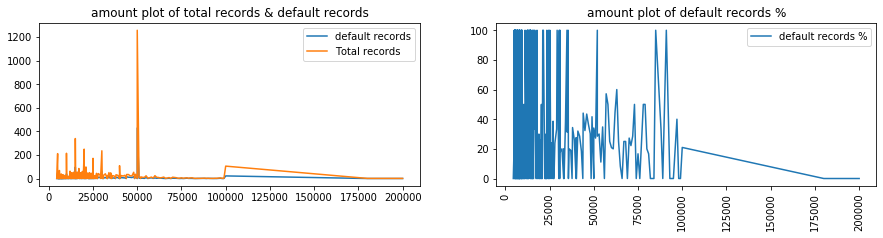

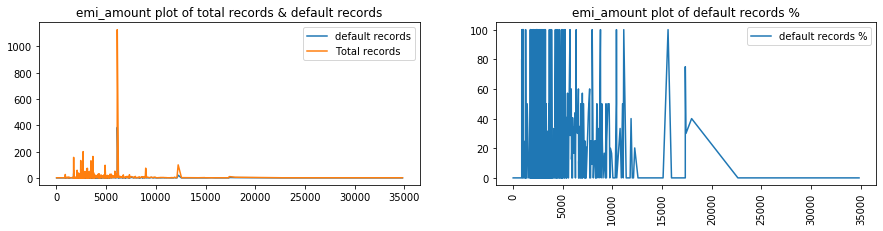

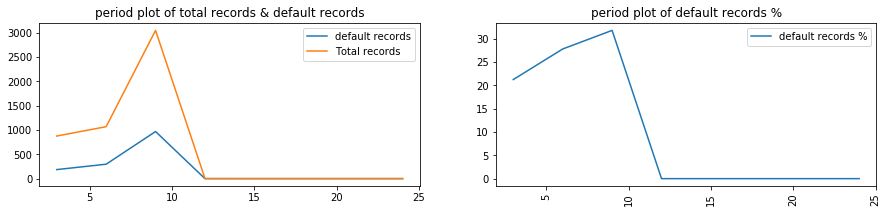

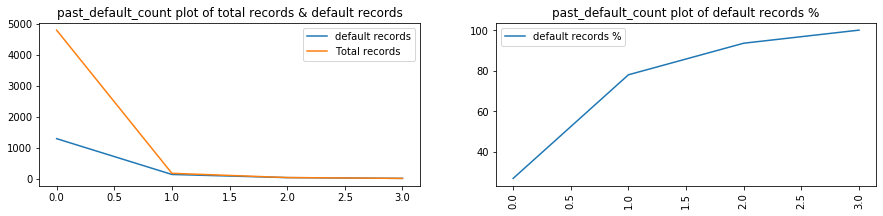

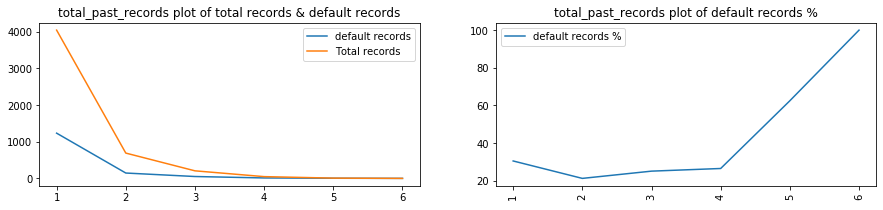

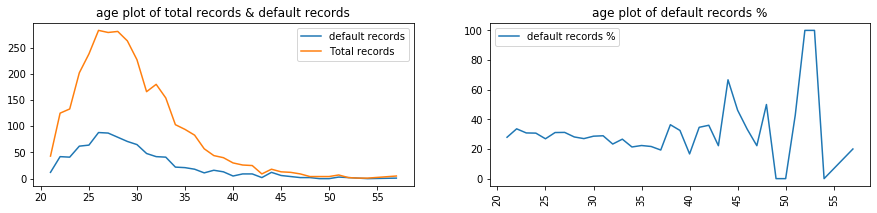

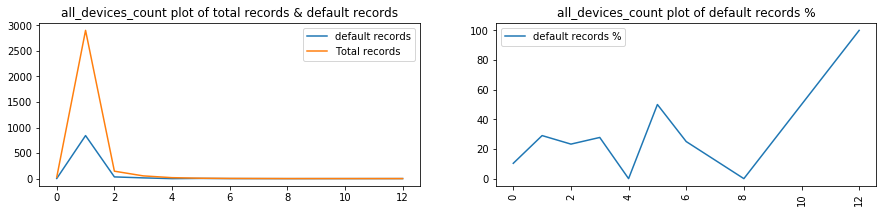

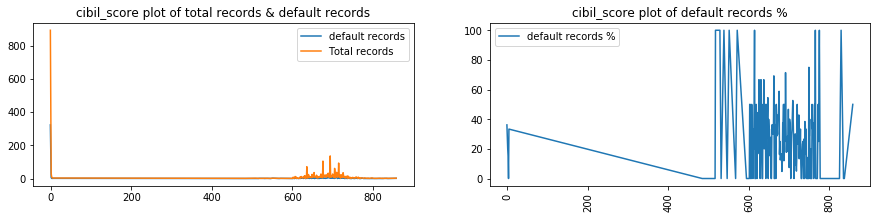

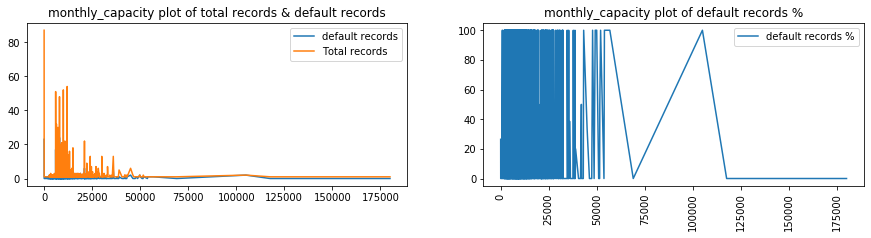

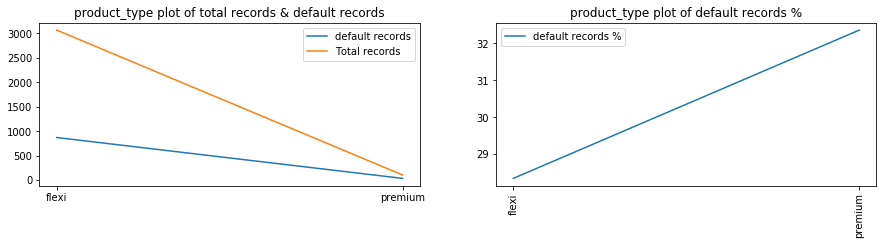

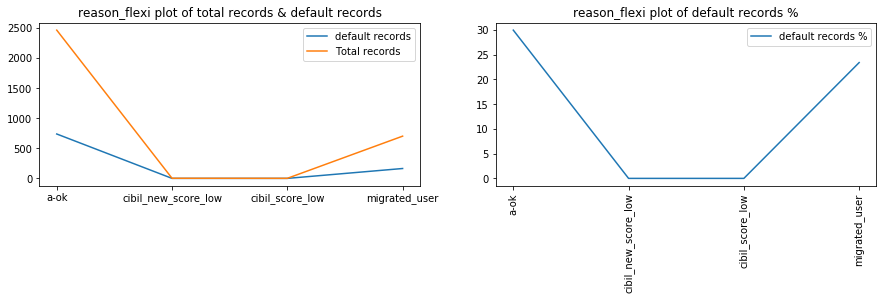

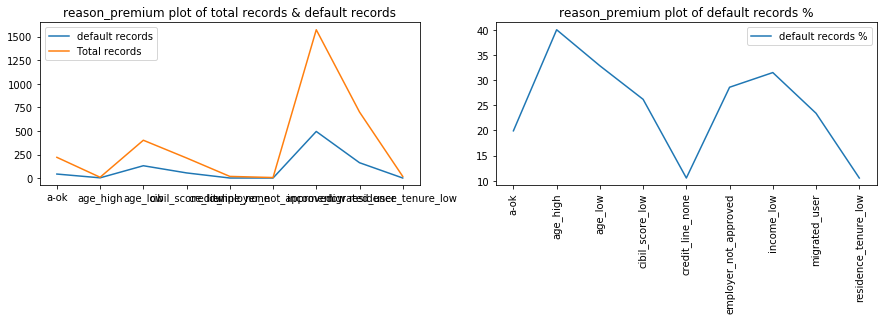

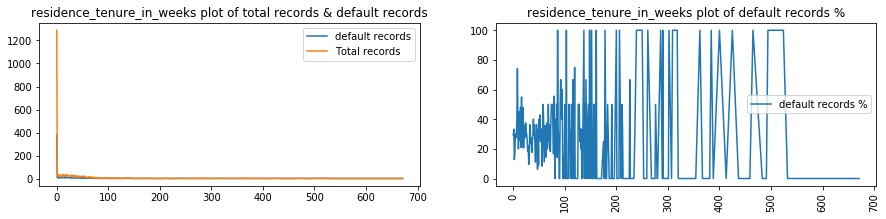

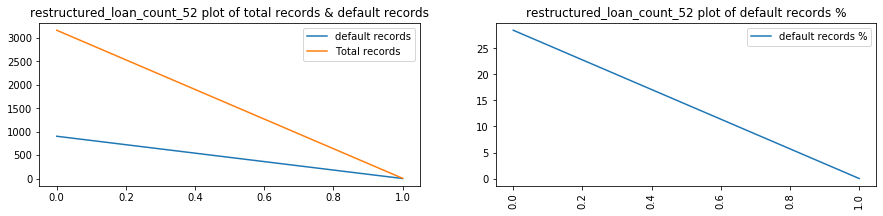

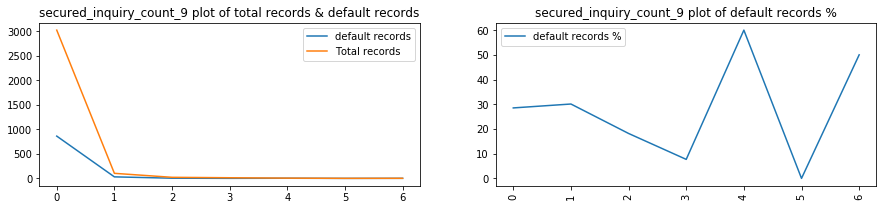

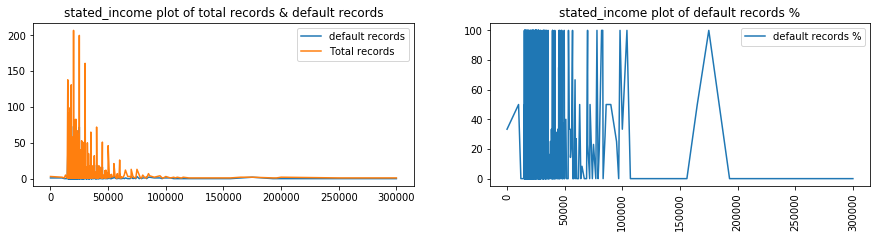

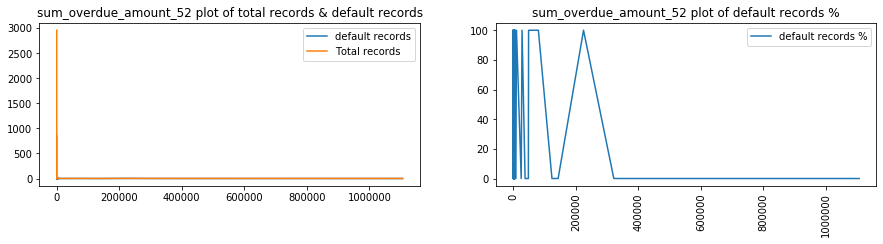

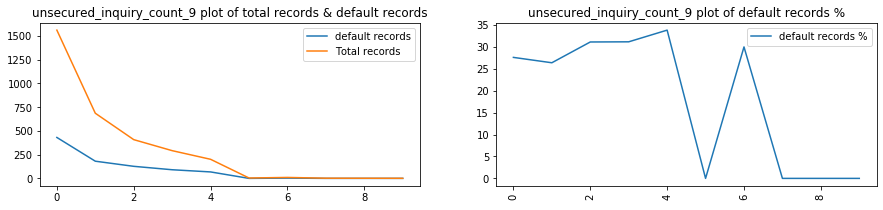

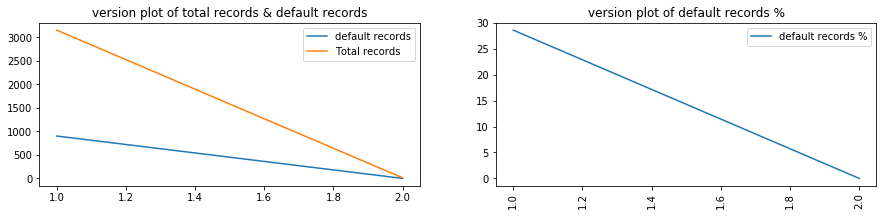

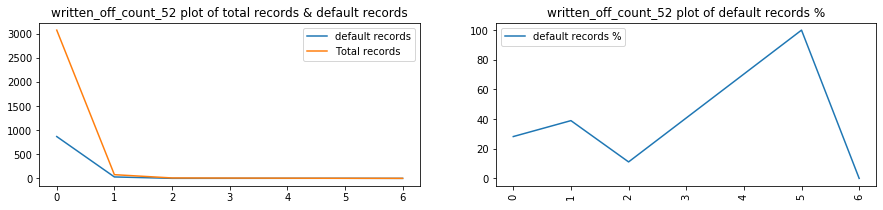

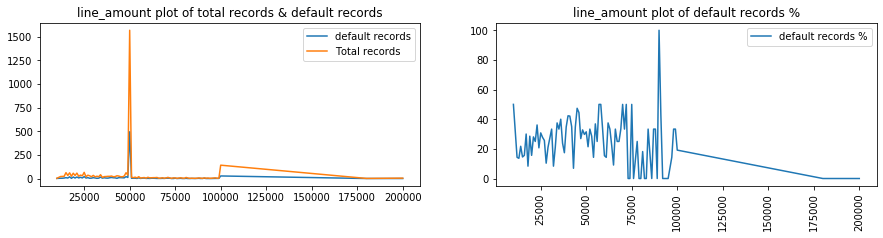

In [22]:
def cal_avg(df):
    sd = pd.Series()
    sd["default"] = len(df[df["target"]=="Default"])
    sd["Total"] = len(df)
    return sd

def cal_relative(df):
    sd = pd.Series()
    sd["default_ratio"] = len(df[df["target"]=="Default"]) / len(df) * 100
    return sd

for column in variable[:]:
    try:
        fig, axs = plt.subplots(1,2, figsize=(15,3))
        plt.xticks(rotation=90)
        
        result = filtered_joined_data.groupby([column]).apply(cal_avg).reset_index()
        axs[0].plot(result[column], result.default, label="default records")
        axs[0].plot(result[column], result.Total, label="Total records")

        axs[0].set_title(column + " plot of total records & default records")
        axs[0].legend()    
        
        result = filtered_joined_data.groupby([column]).apply(cal_relative).reset_index()
        axs[1].plot(result[column], result.default_ratio, label="default records %")

        axs[1].set_title(column + " plot of default records %")
        axs[1].legend() 
        
        plt.show()
    except Exception as e:
        print(repr(e))

Column :-  product_type
target        Default  No Default
product_type                     
flexi             868        2195
premium            33          69
Column :-  reason_flexi
target               Default  No Default
reason_flexi                            
a-ok                   737.0      1724.0
cibil_new_score_low      0.0         2.0
cibil_score_low          0.0         1.0
migrated_user          164.0       537.0
Column :-  is_non_starter
target          Default  No Default
is_non_starter                     
0                1233.0      3547.0
1                 219.0         0.0
Column :-  is_approved_flexi
target             Default  No Default
is_approved_flexi                     
0.0                    0.0         3.0
1.0                  901.0      2261.0
Column :-  reason_premium
target                 Default  No Default
reason_premium                            
a-ok                        44         177
age_high                     4           6
age_low          

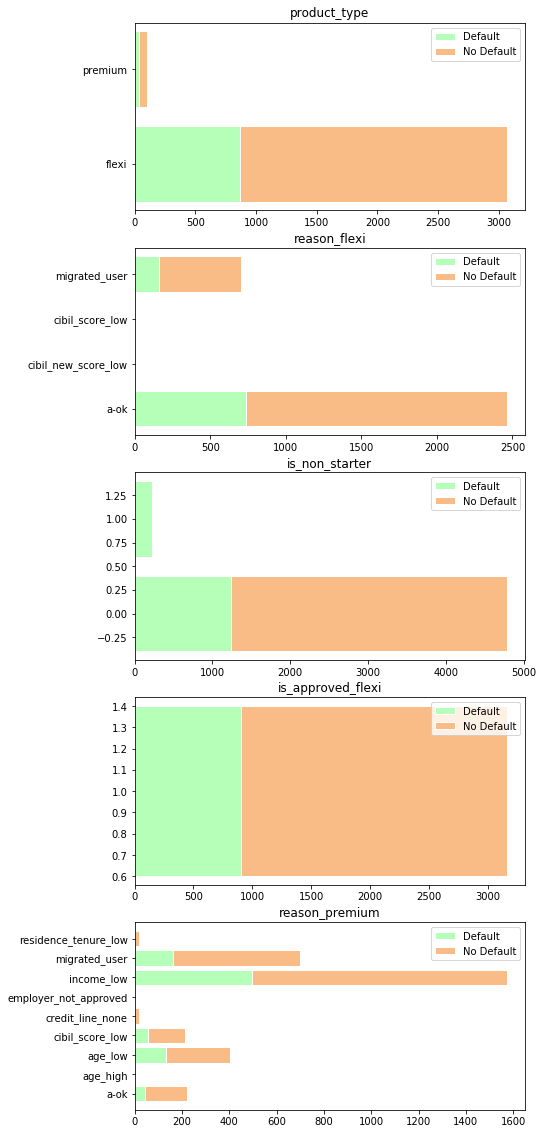

In [23]:
def proportion_plot(df, columns):
    fig, axs = plt.subplots(len(columns),figsize=(7,20))
    pointer = 0
    for column in columns:
        print("Column :- ", column)
        dft = pd.pivot_table(df[[column, "target"]],
                             index=[column],
                             columns=["target"],
                             aggfunc=len)
        print(dft.fillna(0))
        print("="*50)
        legend_pointer = 0
        for i, j in dft.iterrows():
            if legend_pointer == 0:
                axs[pointer].barh(i, j["Default"],
                                  color='#b5ffb9',
                                  edgecolor='white',
                                  label="Default")
                axs[pointer].barh(i, j["No Default"],
                                  left=j["Default"],
                                  color='#f9bc86',
                                  edgecolor='white',
                                  label="No Default"
                                 )
            else:
                axs[pointer].barh(i, j["Default"],
                                  color='#b5ffb9',
                                  edgecolor='white')
                axs[pointer].barh(i, j["No Default"],
                                  left=j["Default"],
                                  color='#f9bc86',
                                  edgecolor='white'
                                 )
            legend_pointer += 1
            axs[pointer].set_title(column)
            axs[pointer].legend()
        pointer += 1
proportion_plot(filtered_joined_data, columns= ["product_type",
                                                "reason_flexi",
                                                "is_non_starter",
                                                "is_approved_flexi",
                                                "reason_premium"
                                               ])

<h3> Weight of evidence :- </h3>
Technique for variable tranformation and selection<br>
<ul>
<li>Here we will transform continuous variable into small bins and tries to find the Information value. Which can tell whether to use them for classification or not.</li>
<li>Also it helps in Identification of bins for each Continuous variable. Which helped in transformation of continuous variables into categorical variables. It helped in creation of bands for each feature, that we can use in training our model.</li>
<li>Also it helped in removal of outlier by making their band with the valid values which lies closer to it.</li>
</ul>

In [24]:
from xverse.transformer import WOE

In [25]:
y = np.where(filtered_joined_data.target == "No Default", 0, 1) 
X = filtered_joined_data.drop("target", axis=1)

In [26]:
exclude_columns = ["product_type", "reason_flexi",
                   "is_non_starter", "is_approved_flexi",
                   "reason_premium"]
clf = WOE(mono_force_bins=4,
          exclude_features=exclude_columns,
          treat_missing='mode',
         )
clf.fit(X, y)

WOE(exclude_features=['product_type', 'reason_flexi', 'is_non_starter',
                      'is_approved_flexi', 'reason_premium'],
    mono_custom_binning={'age': array([21., 26., 28., 32., 57.]),
                         'all_devices_count': array([ 0.,  1., 12.]),
                         'amount': array([  4500.,  15000.,  30000.,  50000., 200000.]),
                         'bank_sms_count': array([   0.,   21.,   93., 1396.]),
                         'cibil_obligations': array([     0. ,   4189.5, 383778. ]),
                         'cibi...
              'unsecured_inquiry_count_9': {Interval(-0.001, 1.0, closed='right'): -0.026735317175186065,
                                            Interval(1.0, 2.0, closed='right'): 0.098992676513726,
                                            Interval(2.0, 9.0, closed='right'): 0.12855411484679025},
              'version': {1.0: 0.00338887644294864, 2.0: 0.0},
              'written_off_count_52': {Interval(-0.001, 1.0, closed='rig

In [27]:
# Info about each bins is present in this variable
bins_info = clf.mono_custom_binning

In [28]:
# As specified in the doc values whith Information Value greater then 0.02 has some explanatory power
features_use = clf.iv_df[clf.iv_df.Information_Value >= 0.02].reset_index(drop=True)

In [29]:
# Feature use has all the continuous variables info 
# regarding their bins that has to be used in Classification modelling in credit_risk_modelling_notebook
features_use["bins"] = features_use["Variable_Name"].map(bins_info)
features_use

,Variable_Name,Information_Value,bins
0,past_default_count,0.252468,"[0.0, 1.0, 2.0, 3.0]"
1,period,0.027442,"[3.0, 6.0, 9.0, 24.0]"
2,amount,0.026612,"[4500.0, 15000.0, 30000.0, 50000.0, 200000.0]"
3,stated_income,0.024796,"[0.0, 19000.0, 24500.0, 32500.0, 300000.0]"
4,line_amount,0.023292,"[10000.0, 35000.0, 50000.0, 200000.0]"
5,total_past_records,0.022990,"[0.5, 1.0, 6.0]"
6,cibil_score,0.021543,"[-1.0, 665.0, 705.0, 858.0]"
